# Rotation and translation of original image


First, we assessed the feasibility of our approach - Can we apply the open3D functions to register our images of zebrafish tailbuds successfully? We reasoned that at bare minimum, for a registration algorithm to have any potential at all at registering separately acquired tailbud images, it must recover the correspondence map between an image and its near-duplicate. In this instance, as we created a near-duplicate that differs from its original merely by rotation and translation operations, we demanded the recovery to be **exact**.

**Objective**: 

Given two images A and A' where A' is identical to image A except for an arbitrary spatial rotation and translation, we assess whether the algorithms are able to recover the exact mapping between image A and A'. 

**Procedure**: 

1. Image A' is generated by randomly rotating and translating the target image in space, and importing the spatial coordinates as a pandas DataFrame.

2. We randomly shuffle the rows of the dataframe of image A' to challenge the algorithms to find the new correspondence map.

3. We visually inspect the results to gather a first impression of the alignment. Following that, the accuracy of the mapping is quantified via the *fitness* and inlier RMSE of the registration, as well as the mean absolute error of sox2 expression between the aligned and original images. 


In [1]:
import RegistrationObj
import scipy.stats as st
from utils import colour_map, min_max_normalisation, mae, mae_permutation
import matplotlib.pyplot as plt
import numpy as np

In [2]:
rotated_target_path = "./datasets/1-rotation/rotated_xyz_target.xls"
target_path = "./datasets/1-rotation/xyz_target.xls"
color_path = "./datasets/1-rotation/sox2_target.xls"


## RANSAC algorithm

In [3]:
myObj_ransac = RegistrationObj.RegistrationObj(rotated_target_path, target_path, color_path, color_path, algorithm = "ransac",
                        pos_skiprows = [0,1,2], pos_usecols = [0,1,2], color_skiprows = [0,1,2], color_usecols = [0])

myObj_ransac.perform_registration()

myObj_ransac.obtain_registration_metrics()


:: RANSAC registration on point clouds.
   Since the  voxel size is 10.000,
   we use a liberal distance threshold 15.000.
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
--- Registration results --- 
Fitness: 78.31%
Inlier RMSE: 4.78
MAE: 0.11
---------------------------------------
--- Correspondence map properties --- 
2442 (64.450%) unmapped targets.
0 (0.000%) targets that are mapped by multiple source points.
1347 (35.550%) targets that are uniquely mapped by a single source point.
All 3789 target points are accounted for.


## ICP algorithm

In [4]:
myObj_icp = RegistrationObj.RegistrationObj(rotated_target_path, target_path, color_path, color_path, algorithm = "icp",
                        pos_skiprows = [0,1,2], pos_usecols = [0,1,2], color_skiprows = [0,1,2], color_usecols = [0])
myObj_icp.perform_registration()
myObj_icp.obtain_registration_metrics()


:: RANSAC registration on point clouds.
   Since the  voxel size is 10.000,
   we use a liberal distance threshold 15.000.
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
--- Registration results --- 
Fitness: 100.00%
Inlier RMSE: 0.00
MAE: 0.00
---------------------------------------
--- Correspondence map properties --- 
0 (0.000%) unmapped targets.
0 (0.000%) targets that are mapped by multiple source points.
3789 (100.000%) targets that are uniquely mapped by a single source point.
All 3789 target points are accounted for.


## Colored ICP algorithm

In [5]:
myObj_colored_icp = RegistrationObj.RegistrationObj(rotated_target_path, target_path, color_path, color_path, algorithm = "colored_icp",
                        pos_skiprows = [0,1,2], pos_usecols = [0,1,2], color_skiprows = [0,1,2], color_usecols = [0])
myObj_colored_icp.perform_registration()
myObj_colored_icp.obtain_registration_metrics()


:: RANSAC registration on point clouds.
   Since the  voxel size is 10.000,
   we use a liberal distance threshold 15.000.
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
--- Registration results --- 
Fitness: 100.00%
Inlier RMSE: 0.00
MAE: 0.00
---------------------------------------
--- Correspondence map properties --- 
0 (0.000%) unmapped targets.
0 (0.000%) targets that are mapped by multiple source points.
3789 (100.000%) targets that are uniquely mapped by a single source point.
All 3789 target points are accounted for.


# Visualisations

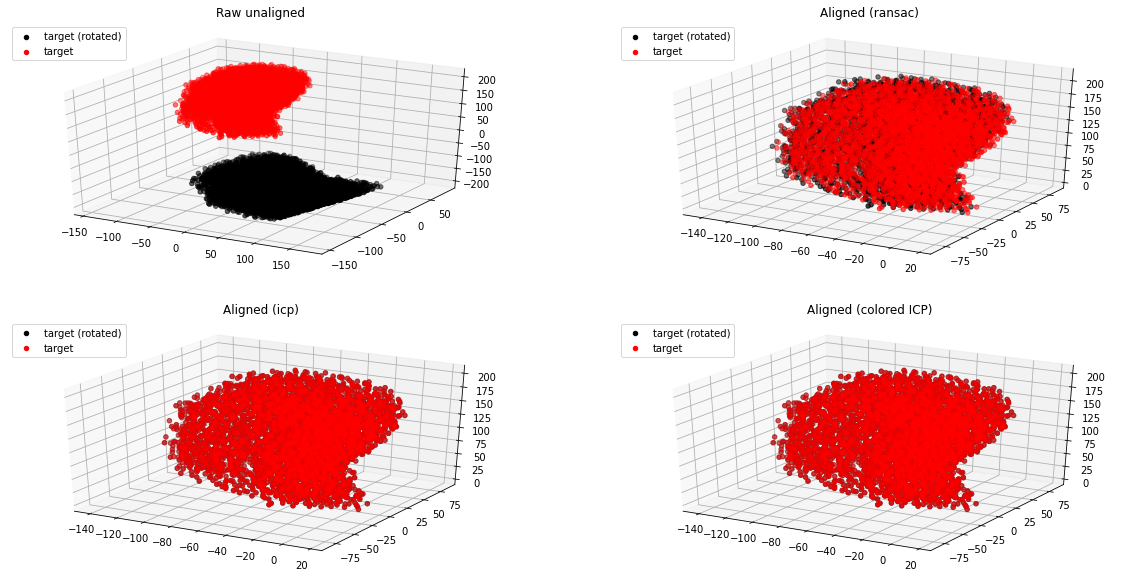

In [6]:
fig = plt.figure(figsize = (20,10))

subplot_loc = [221,222,223,224]
plot_titles = ["Raw unaligned", "Aligned (ransac)", "Aligned (icp)", "Aligned (colored ICP)"]
rotated_target_list = [np.asarray(myObj_ransac.source_pcd.points), np.asarray(myObj_ransac.transform_source().points),
                      np.asarray(myObj_icp.transform_source().points), np.asarray(myObj_colored_icp.transform_source().points)]
target_points = np.asarray(myObj_ransac.target_pcd.points)


for i in range(len(subplot_loc)):
    ax = fig.add_subplot(subplot_loc[i], projection='3d')
    ax.scatter(xs = rotated_target_list[i][:,0], ys = rotated_target_list[i][:,1], zs = rotated_target_list[i][:,2], color='k',label = 'target (rotated)')
    ax.scatter(xs = target_points[:,0], ys = target_points[:,1], zs = target_points[:,2], color='r',label = 'target')
    ax.title.set_text(plot_titles[i])
    ax.legend(loc='upper left')




# Conclusion

The unregistered target and rotated target images, being non-overlapping, performed the worst on the registration evaluation metrics - it has zero `fitness` and an empty `correspondence set`.

After performing image registration, we observe a maximal fitness of 1.0 with one-to-one correspondence between every single point for two of the three algorithms tested (`ICP`, `Colored ICP`), whilst the `RANSAC` algorithm performed suboptimally with only 35% of points mapped. In addition, upon examining the `MAE` metric for the colored ICP algorithm, we observe that the MAE score is 0.0, implying that the spots were mapped correctly.

Furthermore, by visualising the registration result, we observe that the rotated target image has indeed been successfully registered onto its counterpart with the `ICP` or `Colored ICP` algorithms, using the `RANSAC` transformation as input.

Therefore, these algorithms pass the feasibility test as they recovered an exact correspondence map between the target image and its rotated counterpart. 